# Feature Selection & Feature Importances

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

![baby penguin gif from Giphy](https://media.giphy.com/media/RiJuDMqd6vDgfPrZN2/giphy.gif)

Let's hang out with some penguins, loading up a dataset straight from seaborn:

In [2]:
data = sns.load_dataset('penguins')

In [3]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Let's clean up this dataset - two rows have quite a few null values, and 11 total do not have a value for `sex`, so let's drop rows where any data is null:

In [5]:
# Drop nulls here
data = data.dropna(how='any')

In [6]:
# Sanity check
data.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


### Encoding Our Data

In [8]:
data[['species','island','sex']].describe()

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,Male
freq,146,163,168


In order to use the `gender`, `species` or `island` data we need to render those strings as numbers - since there are only 2-3 unique values per column, let's simply one-hot-encode those columns (aka turn the columns into a series of binary indicators).

Using Pandas' `get_dummies` : https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.get_dummies.html

In [25]:
# One hot encode our three 'object' columns
data_num = pd.get_dummies(data, columns=['species', 'island', 'sex'],
                          drop_first=False)

In [26]:
data_num.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,1,0,0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,1,0,0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,1,0,0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,1,0,0,0,0,1,0,1


You'll note that Pandas' `get_dummies` drops the first option, which means one of the species and one of the islands won't be obvious in our features. A thing to keep in mind!

Now let's see what our data looks like...

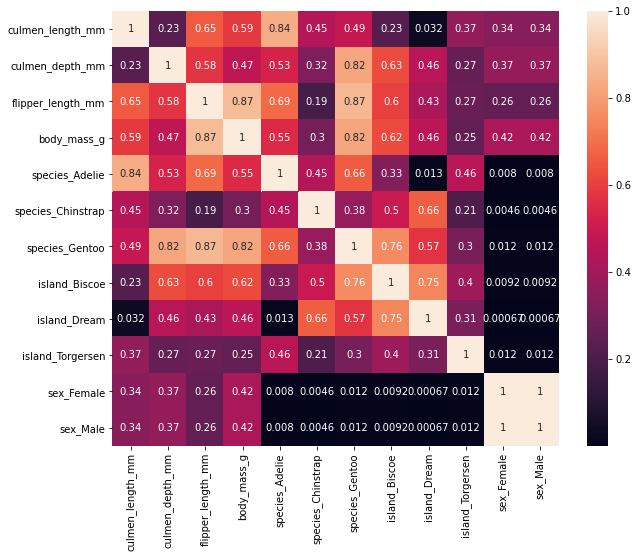

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(data_num.corr().abs(), annot=True)
plt.show()

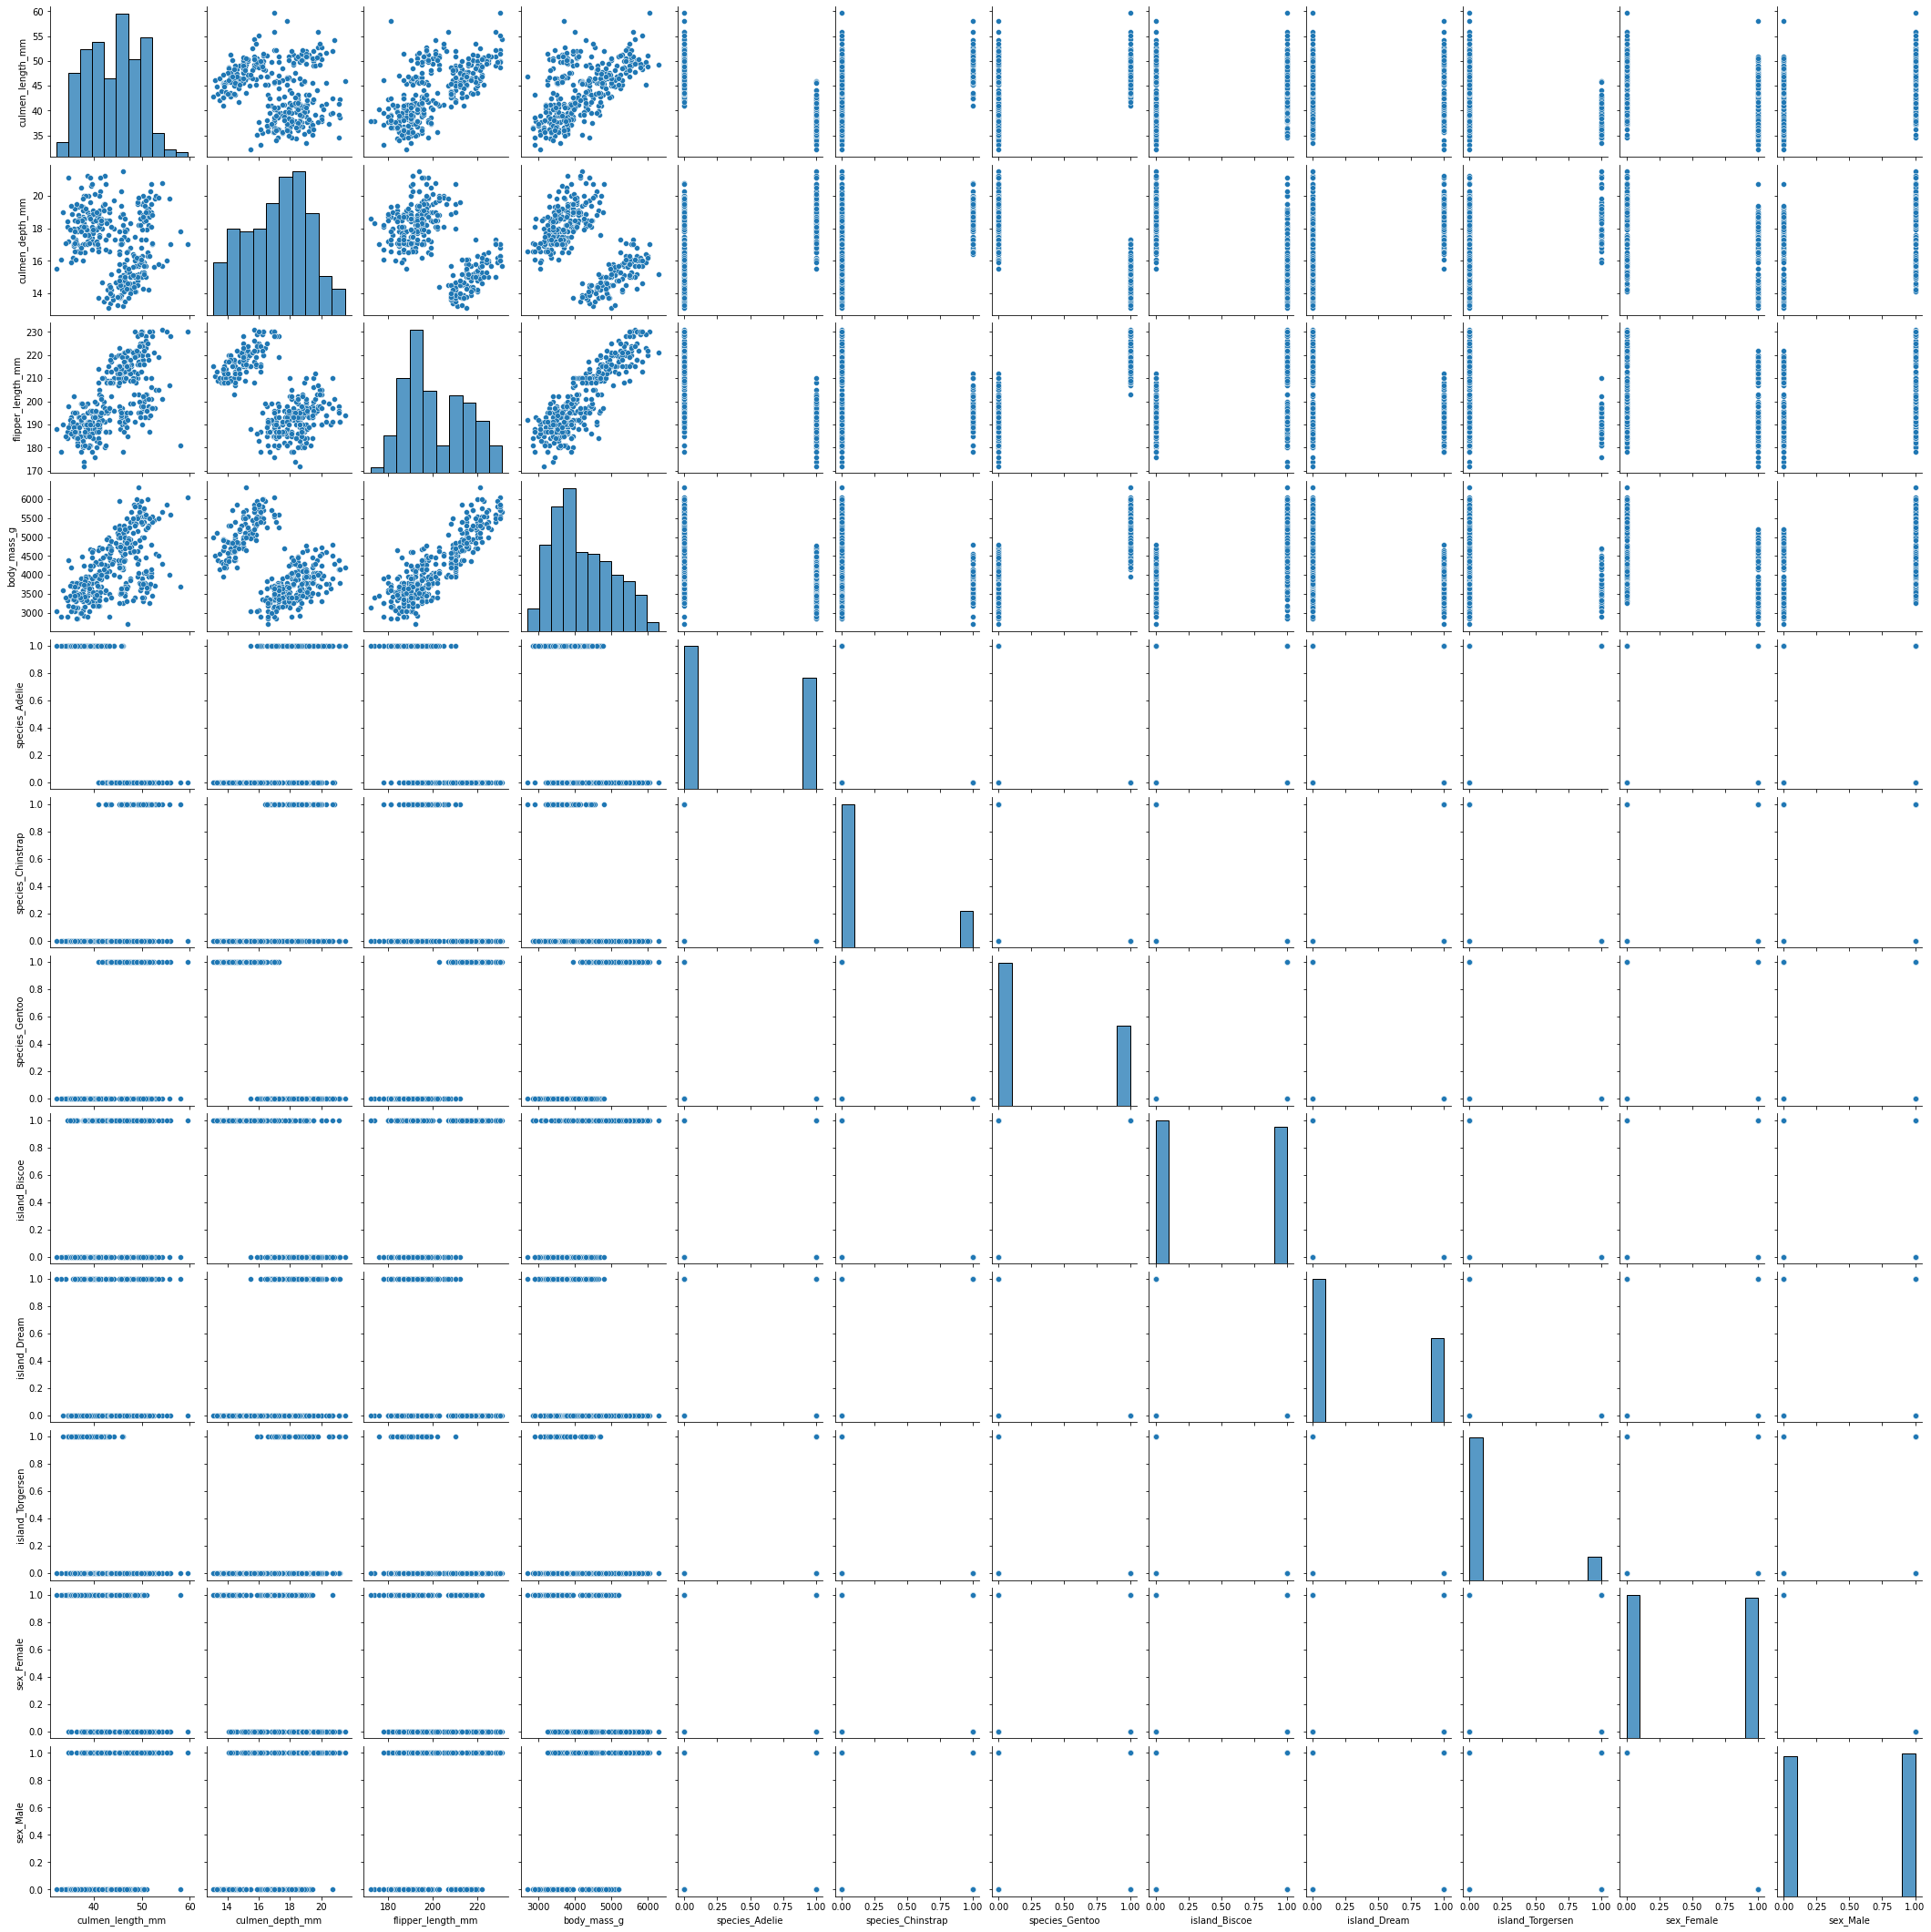

In [28]:
sns.pairplot(data_num)

The goal of this is to predict body mass, `body_mass_g`, so let's define our X and y and perform a train/test split:

In [29]:
# Define X and y
X_cols = [c for c in data_num.columns.to_list() if c not in ['body_mass_g']]

X = data_num[X_cols]
y = data_num.body_mass_g

In [30]:
# Perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
len(X_test) + len(X_train) == len(X)

True

In [32]:
X_train.shape

(249, 11)

In [33]:
X_test.shape

(84, 11)

In [34]:
# Instantiate a scaler
scaler = StandardScaler()

In [35]:
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression Model

In [36]:
# Instantiate a linear regression model
lr = LinearRegression()

In [37]:
# Fit our model on our scaled data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [38]:
# Evaluate
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.8688983108974327
Mean Absolute Error: 236.54272775636218
---
Testing Scores:
R2: 0.8934228693424329
Mean Absolute Error: 199.14395763679508


## Feature Importance through Coefficients

Because we've scaled our data, we can explore our coefficients to see which are having more of an impact on our model.

Note! This, or using p-values from a statsmodels model, is all I expect you to do in this project - anything else we talk about today is completely optional and going above and beyond!

In [39]:
# look at the coefficients with the names of each col
dict(zip(X.columns, lr.coef_))

{'culmen_length_mm': 81.92321677349007,
 'culmen_depth_mm': 140.79466648392884,
 'flipper_length_mm': 230.16982117897322,
 'species_Adelie': -157.31757124177085,
 'species_Chinstrap': -226.2923589891669,
 'species_Gentoo': 354.71575182678043,
 'island_Biscoe': 0.22271453642864714,
 'island_Dream': 9.398266977991792,
 'island_Torgersen': -14.192656393423732,
 'sex_Female': -96.41183479664619,
 'sex_Male': 96.41183479664608}

In [40]:
# let's also look at the intercept
lr.intercept_

4214.357429718875

### So what?

You can use feature importances, or an exploration of statistical significance through statsmodels' provided p-values, to decide which features to keep and which ones to drop in your next iteration of your model! Especially if you OHE a lot of columns, you might use this technique to grab only useful indicators rather than keeping every feature you build in your model.

Will dropping seemingly 'low' features in terms of feature importance always help improve your scores? Nope! Will each way of understanding which feature is 'important' always have the same results? Nope! But try different techniques, see what you think and what helps your model, then iterate.

In terms of interpretation, you may want to get to a final model in terms of what features are used and how you process your data - then build a version of that final model on data that isn't scaled so you can see exactly how each unit of each feature directly impacts your target!

In [41]:
lr_ns = LinearRegression()

lr_ns.fit(X_train, y_train)

# Evaluate
y_train_pred = lr_ns.predict(X_train)
y_test_pred = lr_ns.predict(X_test)

# these scores should be exactly the same
print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")

Training Scores:
R2: 0.8688983108974326
Mean Absolute Error: 236.5427277563622
---
Testing Scores:
R2: 0.8934228693424331
Mean Absolute Error: 199.14395763679508


In [42]:
dict(zip(X.columns, lr_ns.coef_))

{'culmen_length_mm': 15.19558050822272,
 'culmen_depth_mm': 71.93696581716802,
 'flipper_length_mm': 16.632511677752227,
 'species_Adelie': -273.9453372853061,
 'species_Chinstrap': -508.6228217531675,
 'species_Gentoo': 782.5681590384755,
 'island_Biscoe': 8.190144645474412,
 'island_Dream': 27.053892977382525,
 'island_Torgersen': -35.24403762285629,
 'sex_Female': -192.94974850729452,
 'sex_Male': 192.94974850729136}

Rather than interpret anything about this (you can NOT interpret relative feature importances based on unscaled coefficients!!), you can use these coefficients now to discuss how each unit affects the target.

Example: each additional mm of flipper length adds 16.633g of body mass, being a Gentoo penguin adds 1056.513g of body mass, etc.

## Other Feature Importance Methods

There are other ways of exploring feature importances in models beyond just coefficients! Let's explore the documentation...

https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
# Want to try one? Let's pick a method and test it here!

-----

In [43]:
lr_cv = LinearRegression()

In [57]:
results = cross_validate(lr_cv, X_train, y_train, verbose=1, return_estimator=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [58]:
results['test_score'].mean(), results['test_score'].std()

(0.8506295551376735, 0.01716396242066397)

In [63]:
flipper_length_impacts = []
for x in range(5):
    print(results['estimator'][x].coef_)
    flipper_length_impacts.append(results['estimator'][x].coef_[2])

[  17.41954141   95.52381529   16.77398958 -280.67016323 -588.18058456
  868.85074779  -16.75402918   99.63730502  -82.88327584 -174.11214983
  174.11214983]
[  16.18631008   59.59070123   14.18917142 -288.24299697 -493.8497741
  782.09277107  -16.93643022  -14.77760856   31.71403878 -208.32514449
  208.32514449]
[  14.0030213    74.56264444   17.64191638 -292.5746333  -496.8765185
  789.4511518    -6.85005067   50.88422326  -44.03417259 -185.40057763
  185.40057763]
[   9.74195989   71.41117      16.49696605 -320.64743091 -489.22340875
  809.87083966   -3.31993995   15.3027186   -11.98277866 -207.01480483
  207.01480483]
[  17.84471455   63.25196039   18.64333513 -187.1969917  -475.24929346
  662.44628516   89.53815618  -17.75642744  -71.78172874 -184.79288391
  184.79288391]


In [68]:
import numpy as np

In [70]:
np.mean(flipper_length_impacts), np.std(flipper_length_impacts)

(16.749075714776854, 1.4834199115387094)

-----

## Above and Beyond: Regularization Terms

Suppose I have split my data into training and testing sets. Do I want my model to fit my training data _exactly_?

Often, the answer is actually 'NO!', because doing that will lead to an overfit model.

Overfitting is generally a result of high variance. High variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The first problem is about picking up on noise rather than signal.

The second problem is about having a least-squares estimate that is highly sensitive to random error.

The third is about having highly sensitive predictors.

Regularization works by introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

There are two popular ways of doing this:

Lasso ("L1"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|]$
<br/> <br/>

Ridge ("L2"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

**$\rightarrow$ Don't let these formulas be intimidating. The first term in each of these (the sum of squares) is the same, and is just the familiar loss function that we've always used. What distinguishes the Lasso Regression from the Ridge Regression is only the extra term on the right. The Lasso uses the absolute values of the coefficients, while the Ridge uses the squares of the coefficients.**

For a given value of $\lambda$, the Ridge makes for a gentler reining in of runaway coefficients. The Lasso will more quickly reduce the contribution of individual predictors down to insignificance.

For a nice discussion of these methods in Python, see https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b.

**TL;DR:**

- L1 Regularization (LASSO) is good for feature selection

- L2 Regularization (Ridge) is good for reducing the impact of multicollinear features

(also, you can do both at the same time with a technique called [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html))

### L1 Norm: [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

(Least Absolute Shrinkage and Selection Operator)

In [71]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=.5)

In [72]:
# Fit your new L1 model -  on the scaled data
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.5)

In [73]:
# Evaluate
y_train_pred_l1 = lasso.predict(X_train_scaled)
y_test_pred_l1 = lasso.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l1)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l1)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l1)}")

Training Scores:
R2: 0.8688886681043375
Mean Absolute Error: 236.5294591080209
---
Testing Scores:
R2: 0.893662730128251
Mean Absolute Error: 198.99087446842637


Remember - what's the benefit of using LASSO?

In [74]:
print("Unpenalized Linear Regression Coefficients are: {}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept: {}".format(lr.intercept_))
print("---")
print("Lasso Regression Coefficients are: {}".format(lasso.coef_))
print("Lasso Linear Regression Intercept: {}".format(lasso.intercept_))

Unpenalized Linear Regression Coefficients are: [ 8.19232168e+01  1.40794666e+02  2.30169821e+02 -1.57317571e+02
 -2.26292359e+02  3.54715752e+02  2.22714536e-01  9.39826698e+00
 -1.41926564e+01 -9.64118348e+01  9.64118348e+01]
Unpenalized Linear Regression Intercept: 4214.357429718875
---
Lasso Regression Coefficients are: [ 8.10184934e+01  1.35900186e+02  2.31472957e+02 -1.90490530e+01
 -1.09914532e+02  4.83021105e+02 -0.00000000e+00  6.74769304e+00
 -1.45942908e+01 -1.94248453e+02  5.43550925e-13]
Lasso Linear Regression Intercept: 4214.357429718875


### L2 Norm: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [75]:
# Instantiate a lasso regression model
ridge = Ridge(alpha=.5)

In [76]:
# Fit your new L2 model -  on the scaled data
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.5)

In [77]:
# Evaluate
y_train_pred_l2 = ridge.predict(X_train_scaled)
y_test_pred_l2 = ridge.predict(X_test_scaled)

print("Training Scores:")
print(f"R2: {r2_score(y_train, y_train_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_l2)}")
print("---")
print("Testing Scores:")
print(f"R2: {r2_score(y_test, y_test_pred_l2)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_l2)}")

Training Scores:
R2: 0.8688884985275407
Mean Absolute Error: 236.55306454642272
---
Testing Scores:
R2: 0.8936866247774298
Mean Absolute Error: 198.87405218173487


In [78]:
print("Unpenalized Linear Regression Coefficients are:{}".format(lr.coef_))
print("Unpenalized Linear Regression Intercept:{}".format(lr.intercept_))
print("---")
print("Ridge Regression Coefficients are:{}".format(ridge.coef_))
print("Ridge Linear Regression Intercept:{}".format(ridge.intercept_))

Unpenalized Linear Regression Coefficients are:[ 8.19232168e+01  1.40794666e+02  2.30169821e+02 -1.57317571e+02
 -2.26292359e+02  3.54715752e+02  2.22714536e-01  9.39826698e+00
 -1.41926564e+01 -9.64118348e+01  9.64118348e+01]
Unpenalized Linear Regression Intercept:4214.357429718875
---
Ridge Regression Coefficients are:[  83.15171157  135.11144094  231.88062611 -153.97325299 -223.70933731
  349.07300101    1.16597362    8.49885283  -14.2949399   -96.98398781
   96.98398781]
Ridge Linear Regression Intercept:4214.357429718875


All together:

In [79]:
coef_dict = {}
for loc, col in enumerate(data_num.columns):
    coef_dict[col] = {"Unpenalized": lr.coef_[loc-1],
                      "LASSO": lasso.coef_[loc-1],
                      "Ridge": ridge.coef_[loc-1]}
pd.DataFrame.from_dict(coef_dict)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
Unpenalized,9.641183e+01,81.923217,140.794666,230.169821,-157.317571,-226.292359,354.715752,0.222715,9.398267,-14.192656,-96.411835,9.641183e+01
LASSO,5.435509e-13,81.018493,135.900186,231.472957,-19.049053,-109.914532,483.021105,-0.000000,6.747693,-14.594291,-194.248453,5.435509e-13
Ridge,9.698399e+01,83.151712,135.111441,231.880626,-153.973253,-223.709337,349.073001,1.165974,8.498853,-14.294940,-96.983988,9.698399e+01


### Alpha Levels??

We started with the **hyperparameter** alpha set to `0.5` for both our LASSO and Ridge Models: now let's play around with it!

In [80]:
alphas = [.25, .5, 1, 10, 50, 100]

In [81]:
for a in alphas:
    lasso_testing = Lasso(alpha = a)
    lasso_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = lasso_testing.predict(X_train_scaled)
    y_test_pred_testing = lasso_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {lasso_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{lasso_testing.intercept_}")
    print("*" * 20)

Training Scores at alpha: 0.25
R2: 0.868895900199159
Mean Absolute Error: 236.53248120794348
---
Testing Scores at alpha: 0.25
R2: 0.893545878814828
Mean Absolute Error: 199.06741605261067
---
Coefficients at alpha: 0.25 are: [  81.47085508  138.34742626  230.82138911 -180.7293939  -244.71654911
  328.94830358   -0.            7.96455783  -14.46701735 -193.5360613
    0.        ]
Intercept at alpha: 0.25 is:4214.357429718875
********************
Training Scores at alpha: 0.5
R2: 0.8688886681043375
Mean Absolute Error: 236.5294591080209
---
Testing Scores at alpha: 0.5
R2: 0.893662730128251
Mean Absolute Error: 198.99087446842637
---
Coefficients at alpha: 0.5 are: [ 8.10184934e+01  1.35900186e+02  2.31472957e+02 -1.90490530e+01
 -1.09914532e+02  4.83021105e+02 -0.00000000e+00  6.74769304e+00
 -1.45942908e+01 -1.94248453e+02  5.43550925e-13]
Intercept at alpha: 0.5 is:4214.357429718875
********************
Training Scores at alpha: 1
R2: 0.8688564049824091
Mean Absolute Error: 236.53423

In [82]:
for a in alphas:
    ridge_testing = Ridge(alpha = a)
    ridge_testing.fit(X_train_scaled, y_train)
    y_train_pred_testing = ridge_testing.predict(X_train_scaled)
    y_test_pred_testing = ridge_testing.predict(X_test_scaled)

    print(f"Training Scores at alpha: {a}")
    print(f"R2: {r2_score(y_train, y_train_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_testing)}")
    print("---")
    print(f"Testing Scores at alpha: {a}")
    print(f"R2: {r2_score(y_test, y_test_pred_testing)}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_testing)}")
    print("---")
    print(f"Coefficients at alpha: {a} are: {ridge_testing.coef_}")
    print(f"Intercept at alpha: {a} is:{ridge_testing.intercept_}")
    print("*" * 20)

Training Scores at alpha: 0.25
R2: 0.868895790801059
Mean Absolute Error: 236.542358957998
---
Testing Scores at alpha: 0.25
R2: 0.8935594850557345
Mean Absolute Error: 199.0079911585752
---
Coefficients at alpha: 0.25 are: [  82.54853034  137.91224032  231.04834516 -155.61640609 -224.98486657
  351.85090681    0.6989967     8.94461858  -14.24503246  -96.70100331
   96.70100331]
Intercept at alpha: 0.25 is:4214.357429718875
********************
Training Scores at alpha: 0.5
R2: 0.8688884985275407
Mean Absolute Error: 236.55306454642272
---
Testing Scores at alpha: 0.5
R2: 0.8936866247774298
Mean Absolute Error: 198.87405218173487
---
Coefficients at alpha: 0.5 are: [  83.15171157  135.11144094  231.88062611 -153.97325299 -223.70933731
  349.07300101    1.16597362    8.49885283  -14.2949399   -96.98398781
   96.98398781]
Intercept at alpha: 0.5 is:4214.357429718875
********************
Training Scores at alpha: 1
R2: 0.8688610661903515
Mean Absolute Error: 236.59968074113254
---
Testing

### Resources

- [Stats course resource from Penn State](https://online.stat.psu.edu/stat508/lesson/5), going into detail about Regression Shrinkage Methods - aka regularization. This is pretty technical, and the code is in R, but goes into good detail about the motivation of why we do this and how this works.

- Kaggle has a course on Machine Learning interpretability, with a section on [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance) if you'd like to explore that